# Mushroom Detection Model - Test and Implementation

## Import Basic Libraries

In [47]:
# import default libraries 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil
import torch

In [48]:
import ultralytics
ultralytics.checks()

Ultralytics 8.3.17  Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3080 Laptop GPU, 16384MiB)
Setup complete  (16 CPUs, 31.7 GB RAM, 579.5/931.0 GB disk)


In [52]:
from ultralytics import YOLO

In [57]:
test_image_dir = 'mushroom-data/test/images/*'
test_label_dir = 'mushroom-data/test/labels/*'

test_image_path = 'mushroom-data/test/images'
test_label_path= 'mushroom-data/test/labels'

In [50]:
mush_class_dict = {'0': 'Amanita citrina', 
              '1': 'Amanita hemibapha', 
              '2': 'Amanita javanica', 
              '3': 'Amanita pantherina', 
              '4': 'Amanita princeps', 
              '5': 'Boletus reticulatus', 
              '6':'Coltricia perennis', 
              '7': 'Gyromitra infula', 
              '8':'Hygrophoropsis aurantiaca', 
              '9': 'Imleria badia', 
              '10': 'Lactarius turpis', 
              '11': 'Russula emetica', 
              '12': 'Suillus grevillei', 
              '13': 'Suillus luteus'}

In [45]:
def get_ground_truth(image_path, label_dir, class_dict):
    root_name = os.path.basename(image_path).removesuffix('.jpg')
    mush_instances = []
    mush_instance_names = []
    for item in glob.glob(label_dir):
        txt_file = os.path.basename(item)
        if root_name in txt_file:
            file_location = label_dir.strip('*') + '/' + txt_file
            file_data = open(file_location, "r")
            for line in file_data:
                line.split()
                data = line.split(' ')
                mush_class = data[0]
                mush_instances.append(mush_class)
    for mush in mush_instances:
        instance_class = class_dict[mush]
        mush_instance_names.append(instance_class)
    return mush_instance_names
        

In [63]:
import os, glob, random
def randomized_sample(raw_path, sample_size):
    path_list = []
    for i in range(sample_size):
        file = raw_path + '/' + random.choice(os.listdir(raw_path))
        path_list.append(file)
    return path_list

In [93]:
def get_similar_file(original_file_path, new_file_path):
    root_name = os.path.basename(original_file_path)
    for item in glob.glob(new_file_path + '/*'):
        if root_name in item:
            new_file_path = new_file_path + '/' + root_name
            return new_file_path
    

In [90]:
print(get_similar_file('runs/detect/predict/11264medium_jpeg.rf.a035d2aec0e8b006c4301bfa1c71cfd2.jpg', 'runs/detect/predict2'))

runs/detect/predict2/11264medium_jpeg.rf.a035d2aec0e8b006c4301bfa1c71cfd2.jpg


In [60]:
get_ground_truth("mushroom-data/test/images/6652medium_jpg.rf.d2aae7353fc0d694f8215c7b4714ea5f.jpg", test_label_dir, mush_class_dict)

['Coltricia perennis', 'Coltricia perennis', 'Coltricia perennis']

In [102]:
#get randomized sample from test data
mushroom_test_sample = randomized_sample(test_image_path, 20)

In [76]:
# loading small model
mush_model_small = YOLO('models/mushroom_model_small.pt')
mush_model_small.to('cuda')

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_s

In [103]:
# use small model for predictions 
for path in mushroom_test_sample:
    mush_model_small(path, save=True)


image 1/1 C:\Users\alex\Documents\SFU Courses\FALL 2024\IAT 360\Work\Final Project\Mushroom-Detection-Model\mushroom-data\test\images\1976medium_jpeg.rf.1a19a1874db26b22475b77865d8417d5.jpg: 640x480 1 Boletus reticulatus, 47.7ms
Speed: 7.6ms preprocess, 47.7ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict

image 1/1 C:\Users\alex\Documents\SFU Courses\FALL 2024\IAT 360\Work\Final Project\Mushroom-Detection-Model\mushroom-data\test\images\12404medium_jpg.rf.6f92a4d684c8b01d14329a342572d3e0.jpg: 480x640 1 Hygrophoropsis aurantiaca, 46.2ms
Speed: 4.0ms preprocess, 46.2ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict

image 1/1 C:\Users\alex\Documents\SFU Courses\FALL 2024\IAT 360\Work\Final Project\Mushroom-Detection-Model\mushroom-data\test\images\400medium_jpeg.rf.cc9fe8fbda8b5276fd5eb3a04ac865e2.jpg: 448x640 1 Amanita pantherina, 45.2ms
Speed: 2.4ms preprocess, 45.2ms infere

In [78]:
# loading tiny model
mush_model_tiny = YOLO('models/mushroom_model_tiny.pt')
mush_model_tiny.to('cuda')

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [104]:
# use tiny model for predictions 
for path in mushroom_test_sample:
    mush_model_tiny(path, save=True)


image 1/1 C:\Users\alex\Documents\SFU Courses\FALL 2024\IAT 360\Work\Final Project\Mushroom-Detection-Model\mushroom-data\test\images\1976medium_jpeg.rf.1a19a1874db26b22475b77865d8417d5.jpg: 640x480 1 Boletus reticulatus, 18.1ms
Speed: 3.4ms preprocess, 18.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict2

image 1/1 C:\Users\alex\Documents\SFU Courses\FALL 2024\IAT 360\Work\Final Project\Mushroom-Detection-Model\mushroom-data\test\images\12404medium_jpg.rf.6f92a4d684c8b01d14329a342572d3e0.jpg: 480x640 1 Hygrophoropsis aurantiaca, 18.6ms
Speed: 3.2ms preprocess, 18.6ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict2

image 1/1 C:\Users\alex\Documents\SFU Courses\FALL 2024\IAT 360\Work\Final Project\Mushroom-Detection-Model\mushroom-data\test\images\400medium_jpeg.rf.cc9fe8fbda8b5276fd5eb3a04ac865e2.jpg: 448x640 1 Amanita pantherina, 18.7ms
Speed: 2.1ms preprocess, 18.7ms infe

## Show Test Results 

Image Ground Truth Lables: ['Hygrophoropsis aurantiaca', 'Hygrophoropsis aurantiaca', 'Hygrophoropsis aurantiaca', 'Hygrophoropsis aurantiaca']


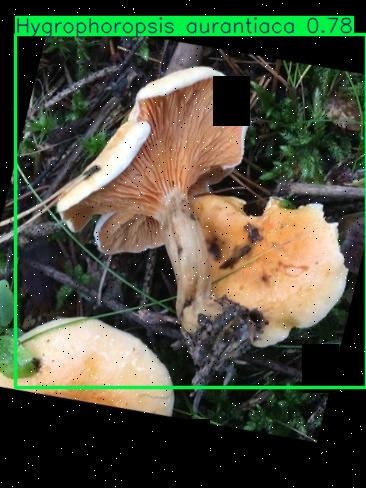

In [100]:
# Show Image stored for small model model 
%matplotlib inline
from PIL import Image
import random, os

#show image for angle prediction
smallmodel_filepath = 'runs/detect/predict'
image_select = random.choice(os.listdir('runs/detect/predict'))
img_path= 'runs/detect/predict/' + image_select
ground_truth = get_ground_truth(img_path, test_label_dir, mush_class_dict)
print(f'Image Ground Truth Lables: {ground_truth}')
Image.open(img_path)

Image Ground Truth Lables: ['Hygrophoropsis aurantiaca', 'Hygrophoropsis aurantiaca', 'Hygrophoropsis aurantiaca', 'Hygrophoropsis aurantiaca']


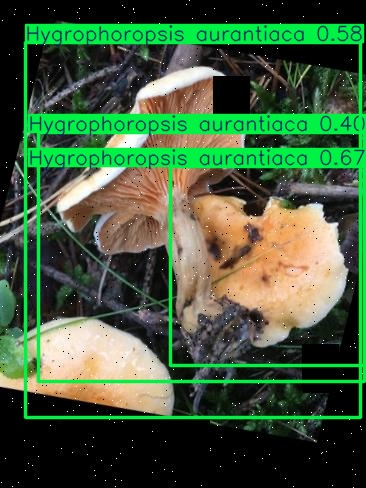

In [101]:
# Show Image stored for tiny model 
%matplotlib inline
img2_path = get_similar_file(img_path, 'runs/detect/predict2')
print(f'Image Ground Truth Lables: {ground_truth}')
Image.open(img2_path)